Using data from Ives et al. "Single Channel Probe Utilizing the EGN Model to Estimate Link Parameters for Network Abstraction"  
Demonstrate the idea of using the physical model to compensate for areas where we dont have much data, which could be because of data acquisition causing a bottleneck (so data is collected where we expect large variations) or just due to missing data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/physical_gps/david_data/'
snr = np.genfromtxt(open(str(data_dir) + "snr_david.csv", "r"), delimiter=",", dtype =float)
pch = np.genfromtxt(open(str(data_dir) + "power_david.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
# snr = snr[:16] # -10 to 5 dBm
# pch = pch[:16] 
snr_comp = snr[:16] # to compare with SSFM
pch_comp = pch[:16] 
snr = snr[1:14]  # -8 to 4 dBm
pch = pch[1:14]  

In [4]:
down_sample_factor = 1
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [5]:
len(pch)

13

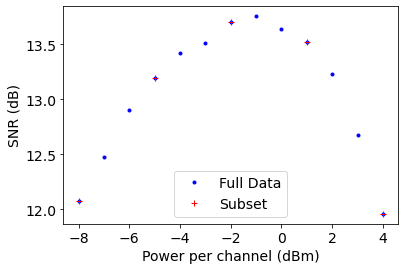

In [6]:
# inds = [0, 4, 8, 12, 15]  # for -10 to 5 dBm
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
inds = [0, 3, 6, 9, 12]  # for -8 to 4 dBm
snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
# inds = [0, 5, 10, -1]
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR mean [dB],  TRx back to back SNR standard dev. [dB], random seed

In [7]:
# def gen_phys_targets(model, pch, num_pts_phys):
#     pch_gn = np.linspace(pch[0], pch[-1], num_pts_phys)
#     snr_phys = (model.predict_snr(pch_gn)).reshape(-1,1)
#     return pch_gn, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-8, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml
def convert_to_lin(x):
    return 10**(x/10)
def convert_to_db(x):
    return 10*np.log10(x)
def convert_to_dbm(x):
    return 10*np.log10(x/1e-3)
def convert_to_lin_dbm(x):
    return 1e-3*convert_to_lin(x)
def predict_snr_david(pch, model, rseed, sig):
    np.random.seed(rseed)
    pch_pert = pch + np.random.normal(0, sig, len(pch))
    ASE_0_david = 4.3e-4*1e-3 # W
    #ASE = phys_model.calc_Pase()
    ASE = phys_model.calc_Pase_Nsp(25)
    Pnli = phys_model.calc_eta(pch_pert)*(convert_to_lin_dbm(pch_pert)**3)
#     trx_btb = 1/29.2
#     return convert_to_db(1/(1/(convert_to_lin_dbm(pch_pert)/(ASE_0_david*10 + Pnli)) + trx_btb )) # paper values
    trx_btb = 1/29.2
    return convert_to_db(1/(1/(convert_to_lin_dbm(pch_pert)/(ASE + Pnli)) + trx_btb )) # values from formula

David's paper: SNR$^{-1}$ = SNR$^{-1}$ + $\mathrm{{SNR}_0}^{-1}$  
$\mathrm{{SNR}_0}=29.2=14.7$dB  
New model: 1/SNR$_{phys}$ = 1/SNR + N(-14.7, 0.01$\times$-14.7)

Comments from David - the bandwidth used to infer the NF from the fitted ASE noise term is equal to the symbol rate of 11.5 GBd.  

"It says the receiver filter bandwidth. What I mean is the noise bandwidth used depends on the receiver matched filter. Assuming the DSP adapts to the ideal matched filter then for white noise the effective noise bandwidth would be equal to the symbol rate. The actual signal will be broader than this but for the noise the equivalent rectangular shape will have a width equal to the symbol rate. So for example the ASE noise impacting the result will be equal to the PSD of the ASE times the symbol rate. And the signal will be the total power."

Calculate the value of $\alpha$ (dB) required to obtain the quoted value of ASE noise power with quoted NF = 4.6 dB

In [8]:
convert_to_db((4.3e-4*1e-3/(convert_to_lin(4.6)*6.63e-34*(3e8/1550e-9)*11.5e9) + 1))/100

0.20087448955830728

In [18]:
Nsp = (convert_to_lin(4.6)*convert_to_lin(25))/(2*(convert_to_lin(25) - 1))
2*Nsp

2.893180543325598

In [19]:
convert_to_lin(4.6)

2.8840315031266055

In [11]:
convert_to_db((4.3e-4*1e-3)/(6.63e-34*(3e8/1550e-9)*(convert_to_lin(0.2*100) - 1)*11.5e9))

4.688323356742809

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient[1/(W*km)], dispersion coefficient[ps^2/km], loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back NSR [dB], TRx back to back NSR std [dB], random seed 

In [26]:
placeholder = 1
#phys_model = GN_model(100, 1550, 1, 0.72, 18, 0.2, 11.5, 40.2, 50, 3, 10, placeholder, placeholder, 4)
#phys_model = GN_model(100, 1550, 1, 0.72, 16.5, 0.2, 11.5, 41.6, 50, 4.6, 10, placeholder, placeholder, 4)
phys_model = GN_model(100, 1550, 1, 1.2, 17, 0.2, 11.5, 41.6, 50, 4.6, 10, placeholder, placeholder, 4)

In [27]:
pch_gn_comp = np.linspace(pch[0], pch[-1], 30)
snr_phys_david = predict_snr_david(pch_gn_comp, phys_model, 2, 0.5/3)  # ASE and TRx back to back noise are both given by paper

In [28]:
def apply_b2b(snr, b2b):
    return convert_to_db(1/(1/convert_to_lin(snr) + 1/convert_to_lin(b2b)))
# snr_ssfm = [13.78, 14.78, 15.75, 16.74, 17.7, 18.63, 19.52, 20.26, 20.8, 20.98, 20.73, 19.94, 18.7, 17.09, 15.26, 13.28]  
# pch_ssfm = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
snr_ssfm = [13.78, 20.92, 13.04]  
pch_ssfm = [-10, -1, 5]
snr_ssfm_m = [apply_b2b(i, convert_to_db(29.2)) for i in snr_ssfm]
#snr_ssfm_m = [apply_b2b(i, 14.7) for i in snr_ssfm]

In [29]:
snr_phys_ensemble = []
for i in range(5):
    snr_phys_ensemble.append(predict_snr_david(pch, phys_model, i, 0.5/3))

In [30]:
snr_phys_ensemble_ave = np.mean(snr_phys_ensemble, axis=0)
len(snr_phys_ensemble_ave)

13

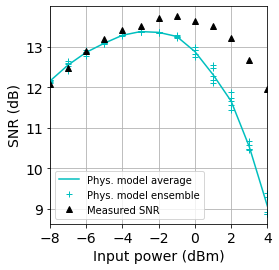

In [53]:
f, ax = plt.subplots()
#plt.plot(pch_comp, snr_comp, 'k^', label='Measured SNR')
#plt.plot(pch_gn_comp, snr_phys_david, 'b-', label='Phys. model')
plt.plot(pch, snr_phys_ensemble_ave, 'c-', label='Phys. model average')
plt.plot(pch, snr_phys_ensemble[0], 'c+', label='Phys. model ensemble')
plt.plot(pch, snr_phys_ensemble[1], 'c+')
plt.plot(pch, snr_phys_ensemble[2], 'c+')
plt.plot(pch, snr_phys_ensemble[3], 'c+')
plt.plot(pch, snr_phys_ensemble[4], 'c+')
#plt.plot(pch_gn_comp, snr_phys_ensemble[5], 'b.')
plt.plot(pch, snr, 'k^', label='Measured SNR')
#plt.plot(pch_ssfm[2:-1], snr_ssfm_m[2:-1], 'r*', label = 'SSFM')
# plt.plot(pch_comp, snr_comp, 'k^', label='Measured SNR')
#plt.plot(pch_ssfm, snr_ssfm_m, 'r*', label = 'SSFM')
#plt.plot(pch_gn_example, snr_phys_example, 'b-', label='Phys. model')
plt.xlim([pch[-1], pch[0]])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
#plt.ylim([11.5, 14])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
#plt.savefig('figures/david_gn_measurements_comp_ppert.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_phys_model_meas_comp.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/ssfm_comp_david.pdf', dpi=200,bbox_inches='tight')
plt.savefig('figures/prior_guesses_GN.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [32]:
num_pts_phys = 15

In [33]:
pch_gn_david = np.linspace(pch[0], pch[-1], num_pts_phys)
snr_gn_david = predict_snr_david(pch_gn_david, phys_model, 1, 0.5/3)

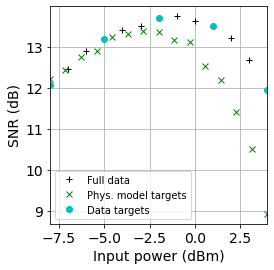

In [34]:
f, ax = plt.subplots()
plt.plot(pch, snr, 'k+', label='Full data')
plt.plot(pch_gn_david, snr_gn_david, 'gx', label='Phys. model targets')
plt.plot(pch_sub, snr_sub, 'co', label='Data targets')
plt.xlim([pch[-1], pch[0]])
#plt.yticks([10,10.5,11,11.5,12, 12.5, 13, 13.5])
#plt.ylim([12, 13.6])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
plt.grid()
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Plot the physical model against measured data.

In [35]:
pch_test = np.copy(pch_gn_david).reshape(-1,1)
snr_phys_test = np.copy(snr_gn_david).reshape(-1,1)

In [36]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub, pch_test, snr_sub, snr_phys_test, pch)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [37]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_sub, snr_sub, pch)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

In [38]:
mu_sk_f, std_sk_f, theta_f, lml_f = train_standard_gp(pch, snr, pch)
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 

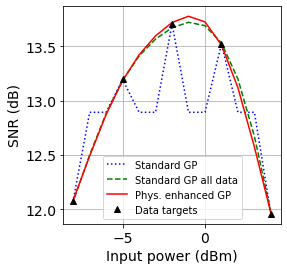

In [39]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b:', label = 'Standard GP')
ax.plot(pch, mu_sk_f, 'g--', label = 'Standard GP all data')
ax.plot(pch, mu_sk_phys, 'r-', label = 'Phys. enhanced GP')
#ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
#ax.plot(pch_shifted, snr,'k+', label='Full data set')
#plt.xlim([pch[0]-0.05, pch[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Predictive mean comparison")
plt.legend(prop={'size':10})
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/david_pred_mean_comp_ppert.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [40]:
pch[-1]

-8.0

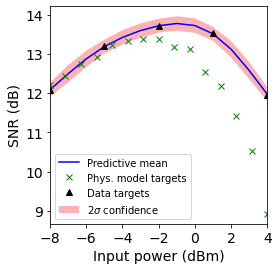

In [43]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_phys, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
#ax.plot(pch_shifted, phys_model_snr_plt, 'k:', label = 'Phys. model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
#plt.xlim([pch[-1], pch[0]])
plt.xlim([-8, 4])
#plt.ylim([11.5, 14.2])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.grid()
#plt.savefig('figures/david_comp_gn_enhanced_gp_ppert.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_phys_gp_comp.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/phys_gp_GN_initial.pdf', dpi=200,bbox_inches='tight')
plt.show()

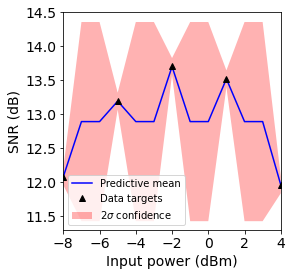

In [44]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch[-1], pch[0]])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
plt.ylim([11.3,14.5])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(loc= 3,prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/david_comp_standard_gp_ppert.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_stan_gp_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

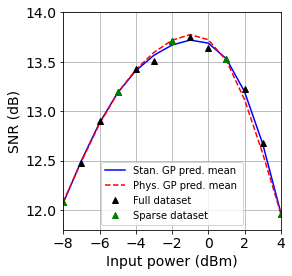

In [45]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_f, 'b-', label = 'Stan. GP pred. mean ')
ax.plot(pch, mu_sk_phys, 'r--', label = 'Phys. GP pred. mean')
ax.plot(pch, snr,'k^', label = 'Full dataset')
ax.plot(pch_sub, snr_sub,'g^', label = 'Sparse dataset')
# ax.fill(np.concatenate([pch, pch[::-1]]),
#             np.concatenate([mu_sk_p2_f,
#                             (mu_sk_n2_f)[::-1]]),
#             alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch[-1], pch[0]])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.ylim([11.8,14])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
#plt.savefig('figures/david_comp_standard_gp_full_ppert.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_comp_stan_gp_full.pdf', dpi=200,bbox_inches='tight')
plt.show()

Compare MSE w.r.t. data for the physical model enhanced GP trained on subset of the data and standard GP trained on full dataset.

In [46]:
mse_phys = np.mean(((snr - mu_sk_phys)**2)**0.5)

In [47]:
mse_stan_f = np.mean(((snr - mu_sk_f)**2)**0.5)

In [48]:
100*(mse_phys - mse_stan_f)/mse_stan_f

2.3520587326900992

MSE difference in dB - way below 0.1 dB, which is the smallest level people care about in power budgets.

In [49]:
mse_phys - mse_stan_f

0.015333678924241867

Only 1% relative difference in the MSE between the physics-enhanced GP and the standard GP trained on the full dataset! 

In [62]:
max(std_sk_f)

array([0.05485771])

In [63]:
max(std_sk_phys)

array([0.10955512])

Relative change in the predictive std (%):

In [64]:
100*(max(std_sk_phys) - max(std_sk_f))/max(std_sk_f)

array([99.70777537])

RMSD of the predictive mean of the model with and without physical models:

In [65]:
np.mean(((mu_sk_f - mu_sk_phys)**2)**0.5)

0.03211684331921724

Mean relative difference (%):

In [66]:
np.mean(100*(mu_sk_f - mu_sk_phys)/mu_sk_f)

0.02768974778532796

In [67]:
np.exp(theta_f)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([1.52049704e+01, 4.98173112e+00, 4.61540319e-03])

In [68]:
np.exp(theta_phys)

array([6.92746514, 4.15680264, 0.00732078])